# Running PyOPIA on EDITO Datalab
This notebook demontrates and end-to-end pipeline analysis of a small image dataset using PyOPIA running on EDITO Datalab.

## Steps
1. Use the "Jupyter-tensorflow" service from the EDITO service catalog. NB: Make sure it is using the Python 3.12 image (under Service )
2. Copy the notebook to the running service
    * E.g. from the DUC6 project file storage, using "mc cp s3/project-dto-bioflow-duc-6/pyopia-process-duc6-edito-uv.ipynb ."
4. Run it. 

In [1]:
packages = [
    "pyopia[classification]",
    "ipywidgets",
    "directory_tree",
]

In [2]:
for package in packages:
    !uv pip install --prefix=".local" {package}

Using CPython 3.12.0
Resolved 200 packages in 134ms                                       
Uninstalled 2 packages in 83ms
Installed 2 packages in 15ms                                
 - click==8.3.1
 + click==8.1.8
 - numpy==2.4.1
 + numpy==2.1.3
Using CPython 3.12.0
Audited 1 package in 6ms
Using CPython 3.12.0
Audited 1 package in 4ms


In [3]:
# Fix a dask issue - maybe related to EDITO container system version of packages
!uv pip install --prefix=".local" --force-reinstall --upgrade xarray==2023.12.0 zarr dask fsspec

Using CPython 3.12.0
Resolved 21 packages in 144ms                                        
Prepared 21 packages in 0.99ms                                           
Uninstalled 21 packages in 345ms
Installed 21 packages in 104ms0.post0                       
 - click==8.1.8
 + click==8.3.1
 ~ cloudpickle==3.1.2
 ~ dask==2025.12.0
 ~ donfig==0.8.1.post1
 ~ fsspec==2026.1.0
 ~ google-crc32c==1.8.0
 ~ locket==1.0.0
 ~ numcodecs==0.16.5
 - numpy==2.1.3
 + numpy==2.4.1
 ~ packaging==25.0
 ~ pandas==2.3.3
 ~ partd==1.4.2
 ~ python-dateutil==2.9.0.post0
 ~ pytz==2025.2
 ~ pyyaml==6.0.3
 ~ six==1.17.0
 ~ toolz==1.1.0
 ~ typing-extensions==4.15.0
 ~ tzdata==2025.3
 ~ xarray==2023.12.0
 ~ zarr==3.1.5


In [4]:
#
# We need to manually add the package location used for uv pip install above,
# since we cannot install into the system python site-package directory (read-only)
#
import sys

sys.path.insert(0, ".local/lib/python3.12/site-packages")

In [26]:
import contextlib
import tempfile
from collections import namedtuple
from pathlib import Path

import dask.diagnostics
import directory_tree
import matplotlib.pyplot as plt
import numpy as np
import pyopia
import pyopia.cli
import pyopia.instrument.silcam
import pyopia.io
import pyopia.statistics
import pyopia.dataexport.ecotaxa

In [6]:
from xarray.core.parallelcompat import list_chunkmanagers

list_chunkmanagers()

{'dask': <xarray.core.daskmanager.DaskManager at 0x113f40860>}

In [7]:
# PyOPIA version
pyopia.__version__

'2.13.0'

In [8]:
def calculcate_copepod_concentration(
    xstats,
    image_stats,
    cop_prob_lim=0.7,
    path_length_mm=30,
):
    """Calculate copepod concentration (#/L) from PyOPIA stats"""

    # Get xstats for probable copepod particles
    xstats_cop = xstats.where(xstats["probability_copepod"] > cop_prob_lim).dropna(
        dim="index"
    )

    # Recreate PyOPIA config from xstats
    conf = pyopia.io.steps_from_xstats(xstats)
    pixel_size = conf["general"]["pixel_size"]

    # Get number of images
    num_images = image_stats.timestamp.size

    # Get raw image shape
    imx, imy, _ = xstats_cop.attrs["raw_image_shape"]

    # Calculate sample volume
    sample_volume = pyopia.statistics.get_sample_volume(
        pixel_size, path_length_mm, imx=imx, imy=imy
    )

    # Calculate total number of copepods per liter based on total volume sampled
    total_sample_volume = float(sample_volume * num_images)
    num_copepods = xstats_cop.index.size
    copepods_per_litre = float(num_copepods / total_sample_volume)

    return_tuple = namedtuple(
        "CopepodEstimates",
        ["copepods_per_litre", "num_copepods", "total_sample_volume", "num_images"],
    )

    return return_tuple(
        copepods_per_litre=copepods_per_litre,
        num_copepods=num_copepods,
        total_sample_volume=total_sample_volume,
        num_images=num_images,
    )

In [9]:
#
# Create a temporary directory for PyOPIA project data
#
proj_dir_tmp = tempfile.TemporaryDirectory()
proj_dir = Path(proj_dir_tmp.name) / Path("pyopiaproject")
proj_name = proj_dir.name
proj_dir

PosixPath('/var/folders/1l/7d_bgwf50rg_3r0n87kk1h640000gn/T/tmpr7xtpmz7/pyopiaproject')

In [10]:
#
# Initialize PyOPIA project with example data
#
with contextlib.chdir(proj_dir.parent):
    pyopia.cli.init_project(proj_name, instrument="silcam", example_data=True)

Creating PyOPIA project folder pyopiaproject

Creating project folder structure

Downloading PyOPIA example classifier

Generating default PyOPIA config

Adding README file

Creating metadata template file

Downloading example SilCam images

In [11]:
#
# Show the newly created PyOPIA project directory structure
#
directory_tree.DisplayTree(proj_dir, header=True)


$ Operating System : Darwin
$ Path : /var/folders/1l/7d_bgwf50rg_3r0n87kk1h640000gn/T/tmpr7xtpmz7/pyopiaproject

*************** Directory Tree ***************

pyopiaproject/
├── auxillarydata/
│   └── auxillary_data.csv
├── config.toml
├── images/
│   ├── D20220608T184237.407722.silc
│   ├── D20220608T184237.908321.silc
│   ├── D20220608T184238.407874.silc
│   ├── D20220608T184238.907944.silc
│   ├── D20220608T184239.408362.silc
│   ├── D20220608T184239.906522.silc
│   ├── D20220608T184240.407994.silc
│   ├── D20220608T184240.907751.silc
│   ├── D20220608T184241.407779.silc
│   └── D20220608T184241.907751.silc
├── metadata.json
├── processed/
├── pyopia-default-classifier-20250409.keras
└── README


In [12]:
#
# Load PyOPIA config, get stats file and processed directory paths
#
conf = pyopia.io.load_toml(proj_dir / Path("config.toml"))

stats_file = proj_dir / Path(conf["steps"]["output"]["output_datafile"] + "-STATS.nc")
processed_dir = stats_file.parent

conf

{'general': {'raw_files': 'images/*.silc',
  'pixel_size': 28,
  'log_level': 'INFO',
  'log_file': 'pyopia.log'},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'pyopia-default-classifier-20250409.keras'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'average_window': 5,
   'bgshift_function': 'accurate',
   'image_source': 'imraw',
   'divide_bg': True},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'im_corrected'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85,
   'segment_source': 'im_minimum'},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats',
   'export_outputpath': 'roi',
   'roi_source': 'imref'},
  'output': {'pipeline_class': 'pyopia.io.StatsToDisc',
   'output_datafile': 'processed/pyopiaproject',
   'append': False,
   

In [13]:
#
# Generate list of images to be processed
#
with contextlib.chdir(proj_dir):
    img_files = sorted(Path("images").glob("*.silc"))
img_files

[PosixPath('images/D20220608T184237.407722.silc'),
 PosixPath('images/D20220608T184237.908321.silc'),
 PosixPath('images/D20220608T184238.407874.silc'),
 PosixPath('images/D20220608T184238.907944.silc'),
 PosixPath('images/D20220608T184239.408362.silc'),
 PosixPath('images/D20220608T184239.906522.silc'),
 PosixPath('images/D20220608T184240.407994.silc'),
 PosixPath('images/D20220608T184240.907751.silc'),
 PosixPath('images/D20220608T184241.407779.silc'),
 PosixPath('images/D20220608T184241.907751.silc')]

In [14]:
#
# Process images
#
with contextlib.chdir(proj_dir):
    # Initialise the pipeline and run the initial steps
    processing_pipeline = pyopia.pipeline.Pipeline(conf)

    for filename in img_files:
        # Process the image to obtain the stats dataframe
        stats = processing_pipeline.run(str(filename))

/Users/raymondne/projects/2024-DTO-BioFlow/pyopia-edito-tutorial/.local/lib/python3.12/site-packages/pyopia/statistics.py:564: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  np.log(number_distribution[ind], where=number_distribution[ind] > 0),
/Users/raymondne/projects/2024-DTO-BioFlow/pyopia-edito-tutorial/.local/lib/python3.12/site-packages/pyopia/statistics.py:564: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  np.log(number_distribution[ind], where=number_distribution[ind] > 0),
/Users/raymondne/projects/2024-DTO-BioFlow/pyopia-edito-tutorial/.local/lib/python3.12/site-packages/pyopia/statistics.py:564: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  np.log(number_distribution[ind], where=number_distribution[ind] > 0),
/Users/raymondne/projects/2024-DTO-BioFlow/pyopia-edito

In [15]:
#
# Merge per-image stats files into one netcdf
#
with contextlib.chdir(proj_dir):
    pyopia.io.merge_and_save_mfdataset(processed_dir, prefix="pyopiaproject-")

Loading datasets:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
#
# Load stats
#
xstats = pyopia.io.load_stats(str(stats_file))
stats = xstats.to_pandas()
stats["depth"] = np.random.uniform(5, 15, size=xstats.index.size)
pyopia.statistics.add_best_guesses_to_stats(stats)
stats

,major_axis_length,minor_axis_length,equivalent_diameter,minr,minc,maxr,maxc,probability_bubble,probability_copepod,probability_diatom_chain,...,probability_oil,probability_oily_gas,probability_other,export_name,timestamp,saturation,depth,temperature,best guess,best guess value
index,,,,,,,,,,,,,,,,,,,,,
0,24.943836,5.815584,10.998080,6.0,2356.0,20.0,2378.0,1.685455e-07,9.943196e-01,7.171003e-04,...,1.969183e-15,0.001407,0.003557,D20220608T184239.906522-PN0,2022-06-08 18:42:39.906522,0.283196,10.872275,7.665109,probability_copepod,0.994320
1,7.585241,5.716893,6.383076,81.0,705.0,89.0,712.0,6.474264e-01,3.203300e-05,2.049788e-02,...,1.423133e-04,0.088287,0.242789,D20220608T184239.906522-PN1,2022-06-08 18:42:39.906522,0.283196,5.375893,7.665109,probability_bubble,0.647426
2,8.866187,5.827813,6.863663,264.0,379.0,273.0,386.0,9.879275e-01,2.417132e-11,1.642436e-06,...,2.959901e-07,0.011957,0.000113,D20220608T184239.906522-PN2,2022-06-08 18:42:39.906522,0.283196,9.025946,7.665109,probability_bubble,0.987927
3,12.907298,8.118126,9.965575,445.0,500.0,455.0,513.0,6.648662e-03,3.609787e-03,7.223744e-01,...,3.177374e-10,0.009196,0.258157,D20220608T184239.906522-PN3,2022-06-08 18:42:39.906522,0.283196,12.942769,7.665109,probability_diatom_chain,0.722374
4,5.767109,3.399526,4.222008,486.0,4.0,490.0,10.0,1.324403e-04,2.148787e-05,4.301270e-03,...,2.348557e-07,0.000150,0.968150,D20220608T184239.906522-PN4,2022-06-08 18:42:39.906522,0.283196,6.513836,7.665109,probability_other,0.968150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,7.721310,4.694309,6.076508,1732.0,402.0,1739.0,407.0,1.624636e-01,1.371437e-02,2.381287e-03,...,2.074361e-02,0.384059,0.358657,D20220608T184241.907751-PN27,2022-06-08 18:42:41.907751,0.263983,13.138851,7.698463,probability_oily_gas,0.384059
28,7.333898,4.241665,5.527906,1740.0,1738.0,1746.0,1744.0,2.439963e-01,3.098839e-07,1.552419e-05,...,3.388604e-04,0.495700,0.258542,D20220608T184241.907751-PN28,2022-06-08 18:42:41.907751,0.263983,5.132591,7.698463,probability_oily_gas,0.495700
29,5.613546,2.988737,3.908820,1757.0,201.0,1761.0,206.0,8.090259e-01,2.126390e-08,3.896044e-03,...,2.790483e-06,0.024837,0.162091,D20220608T184241.907751-PN29,2022-06-08 18:42:41.907751,0.263983,5.307245,7.698463,probability_bubble,0.809026


In [17]:
#
# Load image stats - contains whole-image statistics
#
image_stats = pyopia.io.load_image_stats(stats_file)
image_stats

<xarray.Dataset>
Dimensions:         (timestamp: 5)
Coordinates:
  * timestamp       (timestamp) datetime64[ns] 2022-06-08T18:42:39.906522 ......
Data variables:
    filename        (timestamp) <U35 'images/D20220608T184239.906522.silc' .....
    particle_count  (timestamp) float64 13.0 25.0 20.0 13.0 32.0
    saturation      (timestamp) float64 0.2832 0.06586 0.05369 0.1627 0.264
    d50             (timestamp) float64 1.883e+03 269.4 240.6 1.351e+03 1.32e+03
    nc              (timestamp) float64 82.68 159.0 127.2 82.68 203.5
    vc              (timestamp) float64 28.82 0.8998 0.6458 10.75 13.7
    sample_volume   (timestamp) float64 0.1572 0.1572 0.1572 0.1572 0.1572
    junge           (timestamp) float64 -2.572 -0.2651 -0.2651 -0.1493 -2.061
    depth           (timestamp) float64 16.65 16.73 16.82 16.9 16.98
    temperature     (timestamp) float64 7.665 7.673 7.682 7.69 7.698

In [18]:
#
# Get particles with high probability of being copepods
#
xstats = xstats.where(xstats["probability_copepod"] > 0.7).dropna(dim="index")
xstats

<xarray.Dataset>
Dimensions:                     (index: 7)
Coordinates:
  * index                       (index) int64 0 9 11 3 5 18 21
    timestamp                   (index) datetime64[ns] 2022-06-08T18:42:39.90...
Data variables: (12/18)
    major_axis_length           (index) float64 24.94 142.3 ... 23.76 17.09
    minor_axis_length           (index) float64 5.816 130.8 ... 5.162 6.674
    equivalent_diameter         (index) float64 11.0 69.03 51.6 ... 10.4 10.52
    minr                        (index) float64 6.0 1.052e+03 ... 1.494e+03
    minc                        (index) float64 2.356e+03 775.0 ... 480.0 19.0
    maxr                        (index) float64 20.0 1.198e+03 ... 1.503e+03
    ...                          ...
    probability_oily_gas        (index) float64 0.001407 8.031e-08 ... 0.01578
    probability_other           (index) float64 0.003557 0.006174 ... 0.1706
    export_name                 (index) object 'D20220608T184239.906522-PN0' ...
    saturation                  (index) float64 0.2832 0.2832 ... 0.264 0.264
    depth                       (index) float64 16.65 16.65 16.9 ... 16.98 16.98
    temperature                 (index) float64 7.665 7.665 7.69 ... 7.698 7.698
Attributes: (12/17)
    steps:                         [general]\nraw_files = "images/*.silc"\npi...
    Modified:                      2026-01-15 10:39:05.839057
    PyOPIA_version:                2.13.0
    title:                         PyOPIA example data
    project_name:                  pyopiaproject
    instrument:                    silcam
    ...                            ...
    creator_email:                 NOT_SPECIFIED
    creator_url:                   NOT_SPECIFIED
    institution:                   NOT_SPECIFIED
    license:                       CC BY-SA 4.0 https://creativecommons.org/l...
    raw_image_shape:               [2056 2464    3]
    classifier_weights_file_hash:  fecf334a0a2fe1d6b59eb93d7fd5bef30c17064cce...

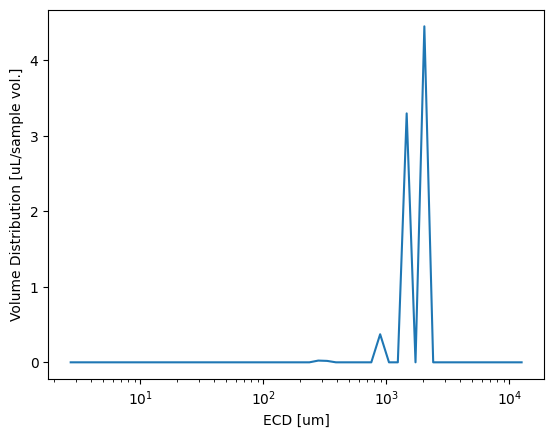

In [19]:
#
# Plot volume distribution from xstats - only copepods [uL / sample vol.]
#
dias, vd_total = pyopia.statistics.vd_from_stats(xstats, conf["general"]["pixel_size"])

plt.plot(
    dias,
    vd_total,
)
plt.xscale("log")
plt.xlabel("ECD [um]")
plt.ylabel("Volume Distribution [uL/sample vol.]")
plt.show()

(80, 12000)

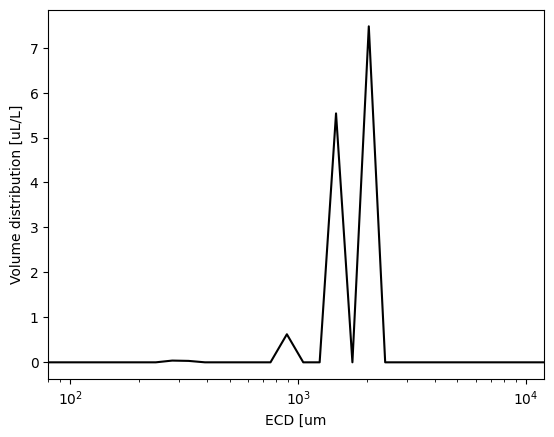

In [20]:
#
# Plot volume distribution from xstats - only copepods [uL / L]
# NB: This needs the correct number of images to get the total sample volume right - use image_stats for that
#
path_length_mm = 30
pixel_size = conf["general"]["pixel_size"]

# Get number of images
nimages = image_stats.timestamp.size

# Get raw image shape
imx, imy, _ = xstats.attrs["raw_image_shape"]

# Calculate sample volume
sample_volume = pyopia.statistics.get_sample_volume(
    pixel_size, path_length_mm, imx=imx, imy=imy
)

# Convert to uL / L
vd_total_scaled = vd_total / (sample_volume * nimages)

plt.plot(dias, vd_total_scaled, "k")
plt.xscale("log")
plt.xlabel("ECD [um")
plt.ylabel("Volume distribution [uL/L]")
plt.xlim(80, 12000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 413.27it/s]


Text(0.5, 1.0, 'Montage based on copepod particles (N=7)')

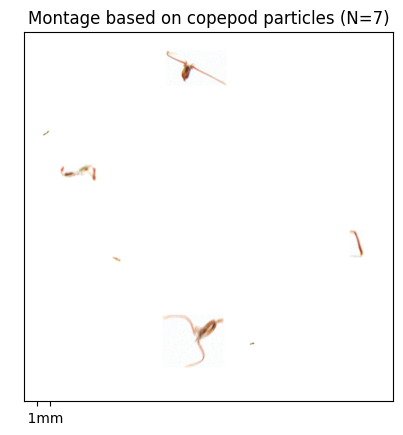

In [21]:
#
# Create montage of copepod particles
#
im_mont = pyopia.statistics.make_montage(
    xstats.to_pandas(),
    pixel_size=pixel_size,
    roidir=str(proj_dir / Path(conf["steps"]["statextract"]["export_outputpath"])),
    auto_scaler=500,
    msize=1024,
    maxlength=100000,
    crop_stats=None,
    eyecandy=True,
)

pyopia.plotting.montage_plot(im_mont, pixel_size)
plt.title(f"Montage based on copepod particles (N={xstats.index.size})")

In [22]:
#
# Calculate total number of copepods per liter based on total volume sampled
#
total_sample_volume = sample_volume * nimages
num_copepods = xstats.index.size
print(f"Total number of images: {nimages}")
print(f"Total volume sampled: {total_sample_volume:.1f} (L)")
print(f"Number of copepods: {num_copepods}")
print(f"Copepods per liter: {num_copepods / total_sample_volume:.2g} (#/L)")

Total number of images: 5
Total volume sampled: 0.6 (L)
Number of copepods: 7
Copepods per liter: 12 (#/L)


In [23]:
#
# Calculate total number of copepods per liter based on total volume sampled
# with custom function defined at the top of this notebook
#
calculcate_copepod_concentration(
    xstats,
    image_stats,
    cop_prob_lim=0.7,
    path_length_mm=30,
)

CopepodEstimates(copepods_per_litre=11.749703418686188, num_copepods=7, total_sample_volume=0.5957597184, num_images=5)

In [42]:
#
# Create EcoTaxa import bundle from potential Copepod particles
#
ecotaxa_export_bundle_filename = "ecotaxa_test_import.zip"
ecotaxa_export = pyopia.dataexport.ecotaxa.EcotaxaExporter()
ecotaxa_export.create_bundle(
    xstats, export_filename=ecotaxa_export_bundle_filename, make_label_folders=False,
    roi_dir=proj_dir / Path("roi")
)

Output()

/Users/raymondne/projects/2024-DTO-BioFlow/pyopia-edito-tutorial/.local/lib/python3.12/site-packages/pyopia/dataexport/ecotaxa.py:168: TqdmExperimentalWarning: rich is experimental/alpha
  tqdm(


In [48]:
# There should be a new file ecotaxa_test_import.zip, containing particle image pngs 
# and particle statistics tsv file. List its content with the zipfile package 
with zipfile.ZipFile(ecotaxa_export_bundle_filename, 'r') as zip_ref:
    print("\n".join(zip_ref.namelist()))

D20220608T184239.906522-PN0.png
D20220608T184239.906522-PN9.png
D20220608T184241.407779-PN11.png
D20220608T184241.907751-PN3.png
D20220608T184241.907751-PN5.png
D20220608T184241.907751-PN18.png
D20220608T184241.907751-PN21.png
ecotaxa_particle_statistics.tsv
